In [1]:
import librosa, librosa.display, librosa.util
import matplotlib.pyplot as plt
import numpy as np

In [2]:
y, sr = librosa.load('./audio/star_synth_fix.wav')
C = np.abs(librosa.cqt(y, sr=sr, hop_length=64, n_bins=84, bins_per_octave=12))

> C - 分音矩阵  
> C.shape - 84个音， 时间帧

(84, 3569)


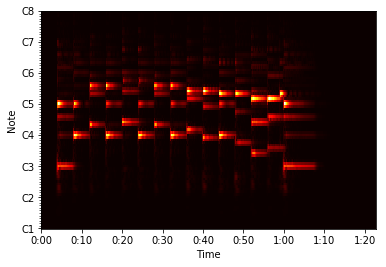

In [3]:
type(C)
print(C.shape)

librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Dimensionality Deduction  
Output: d_C as dimension-deducted C matrix  

Take every 5 frames to 1 using average  
**Time as y_axis, changed from here**  

Calculated after C

In [4]:
d_C = np.zeros([1, C.shape[0]])
local_sum = np.zeros([1, C.shape[0]])
# 84*1


i=0
de_di_rate = 8
for i in range(0, C.shape[1]):
    if (i+1)%de_di_rate != 0:
        local_sum += C[:,i]
    else:
        local_sum /= de_di_rate
        d_C = np.r_[d_C, local_sum]
        local_sum = np.zeros([1, C.shape[0]])
        
if (i+1)%de_di_rate != 0:
    local_sum /= (i+1)%de_di_rate
    d_C = np.r_[d_C, local_sum]

> 检查时间帧顺序，d_C中第一帧的[0]此时可用作参考  

In [5]:
print(d_C)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.04453294e-06 3.50876106e-06 3.50167845e-06 ... 4.63328843e-06
  4.32784500e-06 4.02947288e-06]
 [2.02657459e-06 3.38486411e-06 3.34867168e-06 ... 2.95593732e-06
  4.53892365e-06 3.69163898e-06]
 ...
 [6.27991251e-06 1.78379936e-06 1.56808332e-06 ... 5.85047448e-06
  4.56901938e-06 3.41006359e-06]
 [6.14517823e-06 9.71802061e-07 8.33353803e-07 ... 5.25195269e-06
  4.48880061e-06 2.95599969e-06]
 [7.00222721e-06 9.60262477e-07 8.02286643e-07 ... 7.33180871e-07
  1.06322965e-06 5.37992982e-06]]


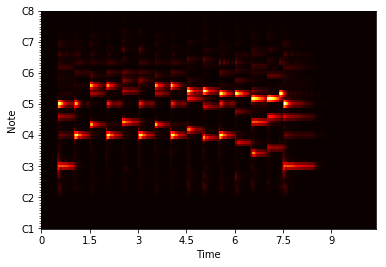

In [6]:
librosa.display.specshow(np.transpose(d_C), sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Denoising  
Output: n_C as normalized C matrix
- Normalization  
- Threshold  

Calculated after d_C

In [7]:
n_C = d_C/np.max(d_C)
SIGMA = 0.1
for i in range(0, n_C.shape[0]):
    for j in range(0, n_C.shape[1]):
        if n_C[i][j] < SIGMA:
            n_C[i][j] = 0
            

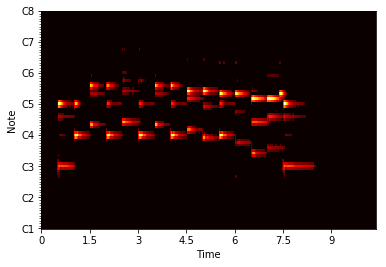

In [8]:
librosa.display.specshow(np.transpose(n_C), sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Euclidean Distance Calculation  
Output: euclidean distance(D) for frequency vectors of adjacent time frames  

${\Sigma_i{{(x[i]-y[i])}}^2}$  

Calculated after n_C  

In [9]:
print(type(n_C), n_C.shape)

<class 'numpy.ndarray'> (448, 84)


In [10]:
D = np.zeros([n_C.shape[0] - 1, n_C.shape[1]])
for i in range(0, n_C.shape[0] - 1):
    D[i] = (n_C[i] - n_C[i+1]) * (n_C[i] - n_C[i+1])

D = D.sum(axis = 1)

# Peak Detection  
Output: onset vectors  

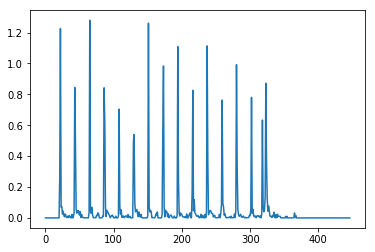

(447,)


In [11]:
plt.plot(range(0, D.shape[0]), D)
plt.show()

print(D.shape)

## 光滑处理  
Output: s_D for Smoothed Distance  
- Smoothing param ${\alpha}$  

In [12]:
ALPHA = 0.4
s_D = np.ndarray(D.shape)

s_D[0] = D[0]
for i in range(1, D.shape[0]):
    s_D[i] = ALPHA * D[i] + (1-ALPHA) * s_D[i-1]

# 双边
for i in range(1, D.shape[0]):
    s_D[i] = ALPHA * s_D[i] + (1-ALPHA) * s_D[i-1]

<class 'numpy.ndarray'> 447
<class 'range'>


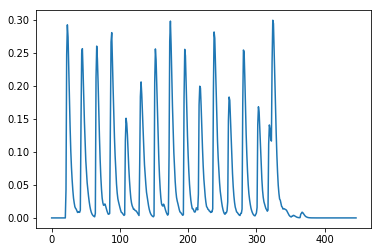

In [13]:
print(type(s_D), len(s_D))
print(type(range(0, len(s_D))))

plt.plot(range(0, s_D.shape[0]), s_D)
plt.show()

# Moving Window Normalization  
Objective: to get a more accurate result of the input distance vector since the volumn are not always the same  
Output: normalized distance vector, n_D  

- ${onset2(n) ={\frac{onset1(n)}{||x||_2}}}$, ${||x||_2 = ({\Sigma}_{i=1}^nx_i^2)^{1/2}}$  
  
  
- $x = (x_i, x_{i+1}, ..., x_{i+hop+overlap})^T, i = 0, 1, ...$
- Window size $i+hop+overlap$ is the sample rate of $onset1$ 

**ATTENTION: If the wave file was silent during some periods, the outcome of the division would be extremly large**

Calculated after the euclidean distance  

In [14]:
# sources from cell 1, librosa.load()
time = librosa.get_duration(y=y, sr=sr)
win = int(s_D.shape[0]/time*3)
overlap = int(win/2)
hop = win-overlap
std = 0
# std for the "extremely large judgement"

n_D = np.ndarray(s_D.shape)
for i in range(0, s_D.shape[0]-win, hop):
    x = 0
    for j in range(i, i + win):
        if j == s_D.shape[0]:
            break
        x += s_D[j] * s_D[j]
    x = np.sqrt(x)
    
    for j in range(i, i + win):
        if j == s_D.shape[0]:
            break
        n_D[j] = s_D[j]/x
        std += n_D[j]

In [15]:
# to cut out the "extremely large" parts
std /= n_D.shape[0]
std *= 100
for i in range(0, n_D.shape[0]):
    if n_D[i] > std:
        n_D[i] = 0

In [16]:
print(s_D[n_D.shape[0]-1])
print(x)

1.0863693792878785e-18
0.9955156958584473


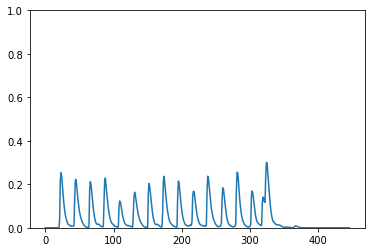

In [17]:
plt.plot(range(0, n_D.shape[0]), n_D)
plt.ylim(0, 1)
plt.show()

# Local Peak Value Extraction  
Output: onset vector  

1. Keep the local maximum  
2. A specified threshold value $\delta$ to filter the local maximums  

In [18]:
onset = np.ndarray(n_D.shape)

onset[0] = 0
sigma = 0
count = 0
for i in range(1, onset.shape[0]-1):
    if(n_D[i-1] <= n_D[i] and n_D[i] >= n_D[i+1]):
        onset[i] = n_D[i]
        sigma += onset[i]
        count += 1
    else:
        onset[i] = 0

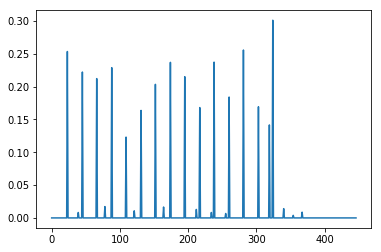

In [19]:
plt.plot(range(0, onset.shape[0]), onset)
plt.show()

In [20]:
sigma = sigma / count * 1.5
for i in range(1, onset.shape[0]):
    if(onset[i] <= sigma):
        onset[i] = 0
    else:
        onset[i] = 1   

In [21]:
print(sigma)
print(sigma*count)
print(count)

0.06666266087476354
5.133024887356792
77


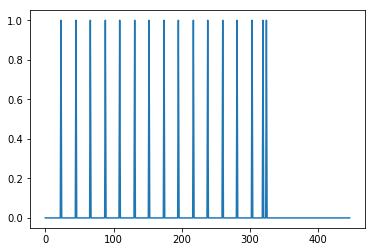

In [22]:
plt.plot(range(0, onset.shape[0]), onset)
plt.show()

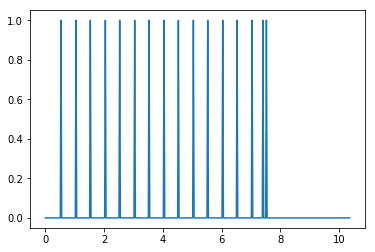

In [23]:
# to time scalar

time = librosa.get_duration(y=y, sr=sr)
time_s = np.linspace(0, time, onset.shape[0])

plt.plot(time_s, onset)
plt.show()